## Etapa 1: Importação das bibliotecas

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
torch.__version__

'1.13.1+cu116'

In [2]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [3]:
dataset_train = datasets.MNIST('MNIST-data', train = True, download = True, transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 256, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



In [4]:
dataset_val = datasets.MNIST('MNIST-data', train = False, download = True, transform = transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 256, shuffle = True)

## Etapa 3: Construção do autoencoder

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Camadas do encoder
        self.enc0 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3))
        self.enc1 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (3, 3), padding = (1, 1))
        self.enc2 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = (3, 3), stride = (2, 2), padding = (1, 1))
        
        self.maxpool0 = nn.MaxPool2d(kernel_size = (2, 2))
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2, 2), padding = (1, 1))
        
        self.flatten = nn.Flatten()
        
        # Camadas do decoder
        self.dec0 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = (3, 3), padding = (1, 1))
        self.dec1 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = (3, 3), padding = (1, 1))
        self.dec2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        self.dec3 = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = (3, 3), padding = (1, 1))
        
        self.upsampling = nn.UpsamplingBilinear2d(scale_factor = 2) # como todo maxpooling era kernel_size = 2 (o que implica em fator de escalonamento = 0.5), agora eu posso usar o fator inverso, que é 2
        
        # Camadas de ativação
        self.activation0 = nn.ReLU()
        self.activation1 = nn.Sigmoid()
            
    def forward(self, X):
        X = self.maxpool0(self.activation0(self.enc0(X)))
        X = self.maxpool1(self.activation0(self.enc1(X)))
        X = self.flatten(self.activation0(self.enc2(X)))
        X = X.view(-1, 8, 4, 4) # O número de canais (ou filtros) vai na segunda dimensão
        X = self.upsampling(self.activation0(self.dec0(X)))
        X = self.upsampling(self.activation0(self.dec1(X)))
        X = self.upsampling(self.activation0(self.dec2(X)))
        X = self.activation1(self.dec3(X))
        
        return X

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
model = autoencoder()
model.to(device)

autoencoder(
  (enc0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (enc1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dec0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [9]:
for epoch in range(20):
    
    # Treinamento
    running_loss_train = 0.
    for data in loader_train:
        model.train()
        inputs, _ = data # Descartando os rótulos porque não precisamos deles
        inputs = inputs.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()
       
        optimizer.step()

        running_loss_train += loss.item()
    
    # Validação
    running_loss_val = 0.
    for data in loader_val:
        model.eval()
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        running_loss_val += loss.item()

    # Final da época
    print('ÉPOCA {:3d}: perda_train {:.5f} perda_val {:.5f}'.format(epoch + 1, running_loss_train/len(loader_train), running_loss_val/len(loader_val)))


ÉPOCA   1: perda_train 0.32624 perda_val 0.21782
ÉPOCA   2: perda_train 0.19244 perda_val 0.17442
ÉPOCA   3: perda_train 0.16414 perda_val 0.15428
ÉPOCA   4: perda_train 0.15033 perda_val 0.14673
ÉPOCA   5: perda_train 0.14415 perda_val 0.14071
ÉPOCA   6: perda_train 0.14020 perda_val 0.13748
ÉPOCA   7: perda_train 0.13737 perda_val 0.13492
ÉPOCA   8: perda_train 0.13515 perda_val 0.13264
ÉPOCA   9: perda_train 0.13320 perda_val 0.13211
ÉPOCA  10: perda_train 0.13155 perda_val 0.12946
ÉPOCA  11: perda_train 0.13007 perda_val 0.12887
ÉPOCA  12: perda_train 0.12873 perda_val 0.12671
ÉPOCA  13: perda_train 0.12731 perda_val 0.12537
ÉPOCA  14: perda_train 0.12616 perda_val 0.12483
ÉPOCA  15: perda_train 0.12503 perda_val 0.12374
ÉPOCA  16: perda_train 0.12395 perda_val 0.12236
ÉPOCA  17: perda_train 0.12291 perda_val 0.12200
ÉPOCA  18: perda_train 0.12201 perda_val 0.12050
ÉPOCA  19: perda_train 0.12124 perda_val 0.12234
ÉPOCA  20: perda_train 0.12045 perda_val 0.11846


## Etapa 5: Geração do encoder

In [10]:
for i, layer in enumerate(list(model.children())):
    print(i, layer)

0 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
1 Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
4 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
5 Flatten(start_dim=1, end_dim=-1)
6 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
9 Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
11 ReLU()
12 Sigmoid()


In [11]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc0 = list(model.children())[0]
        self.enc1 = list(model.children())[1]
        self.enc2 = list(model.children())[2]
    
        self.maxpool0 = list(model.children())[3]
        self.maxpool1 = list(model.children())[4]
        
        self.flatten = list(model.children())[5]
        
        self.activation0 = list(model.children())[11]
    
    def forward(self, X):
        X = self.maxpool0(self.activation0(self.enc0(X)))
        X = self.maxpool1(self.activation0(self.enc1(X)))
        X = self.flatten(self.activation0(self.enc2(X)))
        
        return X

In [12]:
model1 = encoder()
model1.to(device)

encoder(
  (enc0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (enc1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [13]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec0 = list(model.children())[6]
        self.dec1 = list(model.children())[7]
        self.dec2 = list(model.children())[8]
        self.dec3 = list(model.children())[9]
    
        self.upsampling = list(model.children())[10]
        
        self.activation0 = list(model.children())[11]
        self.activation1 = list(model.children())[12]
        
    def forward(self, X):
        X = X.view(-1, 8, 4, 4)
        X = self.upsampling(self.activation0(self.dec0(X)))
        X = self.upsampling(self.activation0(self.dec1(X)))
        X = self.upsampling(self.activation0(self.dec2(X)))
        X = self.activation1(self.dec3(X))
        
        return X

In [14]:
model2 = decoder()
model2.to(device)

decoder(
  (dec0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [15]:
numero_imagens = 10

imagens_teste = next(iter(loader_val))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [16]:
imagens_teste.shape

torch.Size([10, 1, 28, 28])

In [17]:
# Imagens codificadas 
model1.eval()
imagens_codificadas = model1(imagens_teste)

In [18]:
imagens_codificadas.shape

torch.Size([10, 128])

In [19]:
# Imagens decodificadas
model2.eval()
imagens_decodificadas = model2(imagens_codificadas)

In [20]:
imagens_decodificadas.shape

torch.Size([10, 1, 28, 28])

In [21]:
16 * 8

128

In [22]:
# Formatando as imagens para visualização
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 16, 8)
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

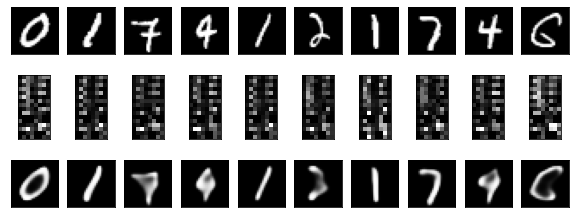

In [23]:
fig, axes = plt.subplots(nrows = 3, ncols = numero_imagens, figsize = (10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)